<a href="https://colab.research.google.com/github/aditij17/Market_Basket_Analysis_Instacart/blob/main/MarketBasketAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing Libraries
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Reading the data
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')

In [ ]:
# Merging order_products_prior with products to get product information
product_info = pd.merge(order_products_prior, products, on='product_id')

product_info.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1.0,1.0,Organic Egg Whites,86,16
1,26,33120,5.0,0.0,Organic Egg Whites,86,16
2,120,33120,13.0,0.0,Organic Egg Whites,86,16
3,327,33120,5.0,1.0,Organic Egg Whites,86,16
4,390,33120,28.0,1.0,Organic Egg Whites,86,16
5,537,33120,2.0,1.0,Organic Egg Whites,86,16
6,582,33120,7.0,1.0,Organic Egg Whites,86,16
7,608,33120,5.0,1.0,Organic Egg Whites,86,16
8,623,33120,1.0,1.0,Organic Egg Whites,86,16
9,689,33120,4.0,1.0,Organic Egg Whites,86,16


In [ ]:
# Computing product popularity based on the frequency in orders
product_popularity = product_info['product_id'].value_counts().reset_index()
product_popularity.columns = ['product_id', 'popularity']

# Adding product names to product_popularity DataFrame
product_popularity = pd.merge(product_popularity, products[['product_id', 'product_name']], on='product_id')

product_popularity

,product_id,popularity,product_name
0,24852,48374,Banana
1,13176,38642,Bag of Organic Bananas
2,21137,26851,Organic Strawberries
3,21903,24650,Organic Baby Spinach
4,47209,21638,Organic Hass Avocado
...,...,...,...
43751,29749,1,Ultra Antifungal Cream
43752,11415,1,Green Leaf Lettuce
43753,36754,1,Age Defying Classic Cleanser
43754,46185,1,Garden Herb Cheese Alternative Slices


In [ ]:
# Filter based on popularity of the products. Considering products based on their frequency in orders
top_n_popular_products = 150  # Choose the top N popular products
popular_products = product_popularity.head(top_n_popular_products)['product_name']

filtered_data_popularity = product_info[product_info['product_name'].isin(popular_products)]

# Filter based on order size. Considering orders which has more than minimum_order_size products
minimum_order_size = 5  # Choose the minimum order size
order_sizes = filtered_data_popularity['order_id'].value_counts().reset_index()
order_sizes.columns = ['order_id', 'order_size']

filtered_data_order_size = filtered_data_popularity[filtered_data_popularity['order_id'].isin(order_sizes[order_sizes['order_size'] >= minimum_order_size]['order_id'])]

filtered_data_order_size.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
2061,27,28985,16.0,1.0,Michigan Organic Kale,83,4
2063,288,28985,10.0,1.0,Michigan Organic Kale,83,4
2064,331,28985,15.0,0.0,Michigan Organic Kale,83,4
2065,398,28985,4.0,0.0,Michigan Organic Kale,83,4
2066,582,28985,3.0,1.0,Michigan Organic Kale,83,4
2067,588,28985,3.0,1.0,Michigan Organic Kale,83,4
2068,641,28985,1.0,1.0,Michigan Organic Kale,83,4
2069,655,28985,14.0,1.0,Michigan Organic Kale,83,4
2071,859,28985,8.0,0.0,Michigan Organic Kale,83,4
2073,925,28985,21.0,1.0,Michigan Organic Kale,83,4


In [ ]:
# Convert filtered data to transactional dataset format
basket = filtered_data_order_size.groupby(['order_id', 'product_name'])['product_id'].count().unstack().reset_index().fillna(0).set_index('order_id')

# Convert the dataset into a binary matrix representation
# 0 : item not in transaction, 1 : item present in transaction

def encode(t):
    if t<=0:
        return 0
    if t>=1:
        return 1

basket = basket.applymap(encode)

basket.head()

product_name,100% Raw Coconut Water,100% Recycled Paper Towels,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,...,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Unsweetened Vanilla Almond Milk,Vanilla Almond Breeze Almond Milk,Watermelon Chunks,Whipped Cream Cheese,Whole Milk,Yellow Bell Pepper,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
5,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
18,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
26,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Generate frequent itemsets with minimum support
# An itemset should appear in at least 5% of the transactions to be considered frequent
min_support = 0.05  # Set the minimum support threshold
frequent_items = apriori(basket, min_support=min_support, use_colnames=True)

frequent_items.head(10)

,support,itemsets
0,0.076416,(Apple Honeycrisp Organic)
1,0.059187,(Asparagus)
2,0.252975,(Bag of Organic Bananas)
3,0.295158,(Banana)
4,0.071509,(Carrots)
5,0.089485,(Cucumber Kirby)
6,0.068760,(Fresh Cauliflower)
7,0.053237,(Green Bell Pepper)
8,0.065827,(Honeycrisp Apple)
9,0.133727,(Large Lemon)


In [ ]:
# Generate association rules
min_threshold = 0.25  # Set the minimum confidence threshold
rules = association_rules(frequent_items, metric='confidence', min_threshold=min_threshold)
rules.sort_values('confidence', ascending=False, inplace = True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(Organic Avocado),(Banana),0.150956,0.295158,0.057227,0.379098,1.284387,0.012671,1.135189
1,(Organic Hass Avocado),(Bag of Organic Bananas),0.188120,0.252975,0.069423,0.369032,1.458771,0.021833,1.183936
4,(Organic Strawberries),(Bag of Organic Bananas),0.216290,0.252975,0.065122,0.301089,1.190192,0.010407,1.068841
6,(Organic Baby Spinach),(Banana),0.213357,0.295158,0.060991,0.285865,0.968515,-0.001983,0.986987
7,(Organic Strawberries),(Banana),0.216290,0.295158,0.060597,0.280164,0.949199,-0.003243,0.979170
2,(Bag of Organic Bananas),(Organic Hass Avocado),0.252975,0.188120,0.069423,0.274425,1.458771,0.021833,1.118946
0,(Organic Baby Spinach),(Bag of Organic Bananas),0.213357,0.252975,0.055521,0.260226,1.028664,0.001547,1.009802
3,(Bag of Organic Bananas),(Organic Strawberries),0.252975,0.216290,0.065122,0.257426,1.190192,0.010407,1.055397


In [ ]:
# Compute support, confidence, and lift
rules_support = rules['support']
rules_confidence = rules['confidence']
rules_lift = rules['lift']

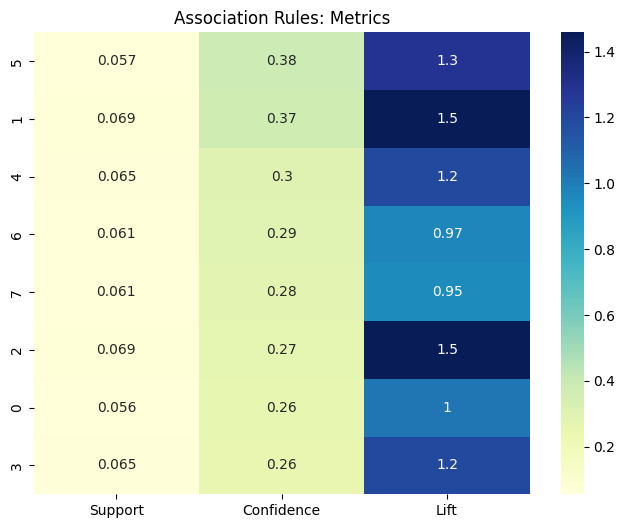

In [ ]:
# Heatmap of support, confidence, and lift
metrics = pd.DataFrame({'Support': rules_support, 'Confidence': rules_confidence, 'Lift': rules_lift})
plt.figure(figsize=(8, 6))
sns.heatmap(metrics, annot=True, cmap='YlGnBu')
plt.title('Association Rules: Metrics')
plt.show()

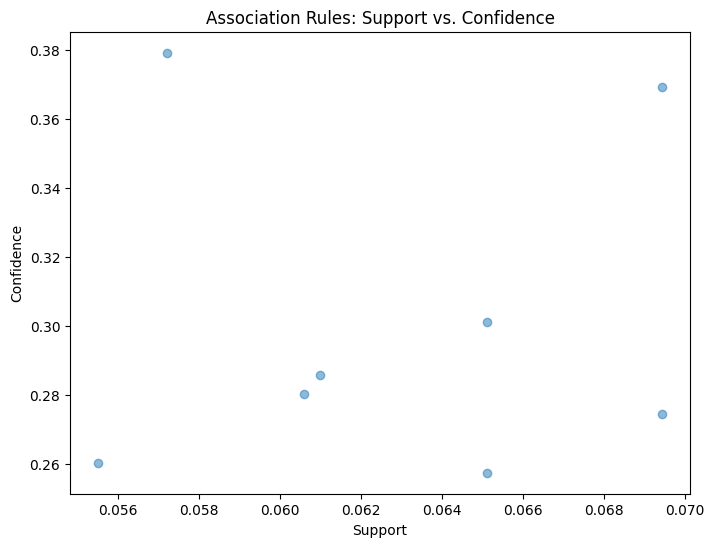

In [ ]:
# Scatter plot of support vs. confidence
plt.figure(figsize=(8, 6))
plt.scatter(rules_support, rules_confidence, alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs. Confidence')
plt.show()

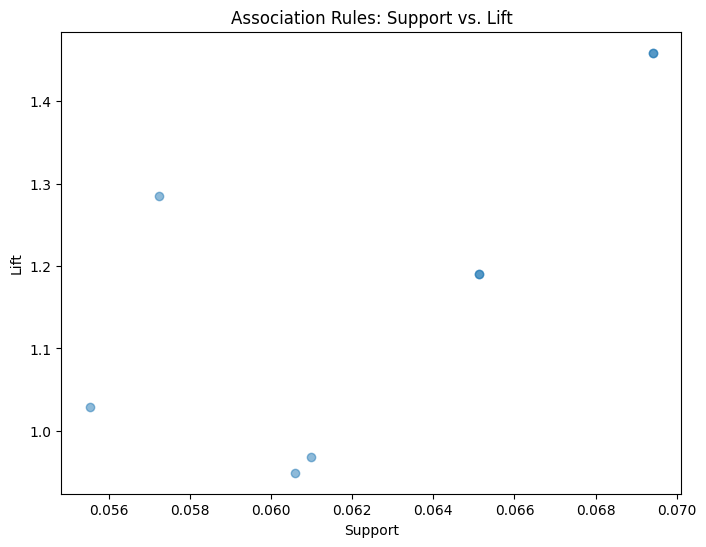

In [ ]:
# Scatter plot of support vs. lift
plt.figure(figsize=(8, 6))
plt.scatter(rules_support, rules_lift, alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Lift')
plt.title('Association Rules: Support vs. Lift')
plt.show()

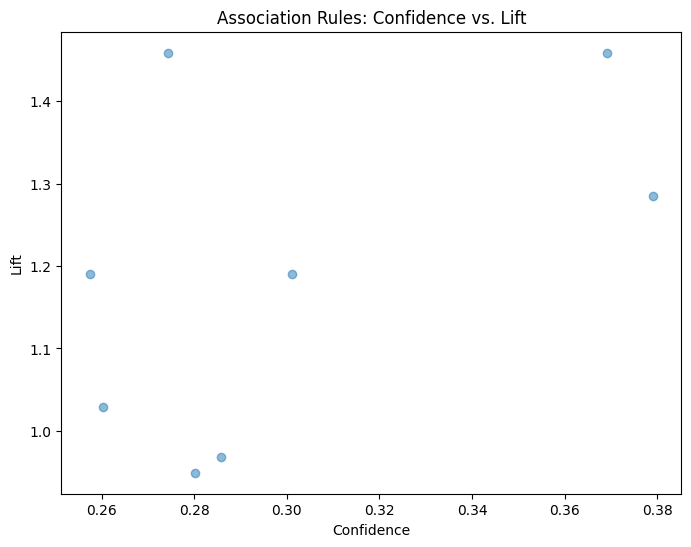

In [ ]:
# Scatter plot of confidence vs. lift
plt.figure(figsize=(8, 6))
plt.scatter(rules_confidence, rules_lift, alpha=0.5)
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Association Rules: Confidence vs. Lift')
plt.show()